##### Created on 04/28/2022

##### This notebook is to get the GCM wind vs M relationship for the oceans over 30N to 70N. Will be compared with MERRA2+MAC and PPE outputs.

##### Updating to retrieve PPE daily data and CESM2 daily data and MERRA2 winds


In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap
from readGCMs import read_var_mod
import calendar
from global_land_mask import globe
import glob

In [2]:
#####Constants
Cp = 1004           #J/kg/K
Rd = 287            #J/kg/K
con= Rd/Cp

# GCM

In [3]:
varname = ['sfcWind', 'tas','psl','ta'] #'sfcWind', 'hfss', 'hfls', 'tas', 'ps', 'psl',
pvarname= ['ta']

In [4]:
#CESM2 2010 to 2015 historical
end = 0
for i in varname: 
    ncname = i+'_day_CESM2_historical_r10i1p1f1_gn_20100101-20150101.nc'
    d_path = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/historical/r10i1p1f1/day/'+i+'/gn/latest/'+ncname
    data =xr.open_dataset(d_path)

    if end == 0:
        lon  = data.variables['lon'][:]  #(lon: 288) [0.0, 1.25, 2.5, ... 356.25, 357.5, 358.75]
        lat  = data.variables['lat'][:]  #(lat: 192) [-90.0 , -89.057592, -88.115183, ... 88.115183,  89.057592, 90.0]
        time = data.variables['time'][:] #(time: 36)

    if i == 'ta':
        lev  = data.variables['plev'][:]
    
    locals()[i+'_0'] = data.variables[i][:]
    print(i+'_0', np.shape(locals()[i+'_0']))

/glade/u/home/geethma/.local/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'sfcWind' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


sfcWind_0 (1826, 192, 288)


/glade/u/home/geethma/.local/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


tas_0 (1826, 192, 288)


/glade/u/home/geethma/.local/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'psl' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


psl_0 (1826, 192, 288)


/glade/u/home/geethma/.local/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'ta' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


ta_0 (1826, 8, 192, 288)


In [5]:
lev

<xarray.IndexVariable 'plev' (plev: 8)>
array([100000.,  85000.,  70000.,  50000.,  25000.,  10000.,   5000.,   1000.])
Attributes:
    axis:           Z
    positive:       down
    requested:      100000. 85000. 70000. 50000. 25000. 10000. 5000. 1000.
    standard_name:  air_pressure
    title:          pressure
    type:           double
    units:          Pa

In [6]:
for j in varname:
    locals()[j+str(0)] = locals()[j+'_'+str(0)][0]
    print(j+'0', np.shape(locals()[j+str(0)]))


sfcWind0 (192, 288)
tas0 (192, 288)
psl0 (192, 288)
ta0 (8, 192, 288)


In [7]:
print(time[0],time[1094])

<xarray.Variable ()>
array(cftime.DatetimeNoLeap(2010, 1, 1, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)
Attributes:
    axis:           T
    bounds:         time_bnds
    standard_name:  time
    title:          time
    type:           double <xarray.Variable ()>
array(cftime.DatetimeNoLeap(2012, 12, 31, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)
Attributes:
    axis:           T
    bounds:         time_bnds
    standard_name:  time
    title:          time
    type:           double


In [8]:
theta_850 = ta_0[:,1,:,:]*(psl_0/85000)**con

In [9]:
M = tas_0 - theta_850

In [8]:
print(np.max(psl_0),np.min(psl_0))
print(np.max(M),np.min(M))
print(np.max(theta_850),np.min(theta_850))

<xarray.Variable ()>
array(106487.484, dtype=float32) <xarray.Variable ()>
array(90942.35, dtype=float32)
<xarray.Variable ()>
array(3.67415032) <xarray.Variable ()>
array(-49.07053573)
<xarray.Variable ()>
array(327.8883658) <xarray.Variable ()>
array(227.26583445)


In [10]:
x_lat = np.array(lat)
lat_ind1 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (30)).argmin()])[0]
lat_ind2 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (70)).argmin()])[0]    

x_lon = lon
# lon_ind1 = np.where(x_lon == x_lon.flat[np.abs(x_lon - (-180)).argmin()])[0]
# lon_ind2 = np.where(x_lon == x_lon.flat[np.abs(x_lon - (180)).argmin()])[0]

x_sfcWind = sfcWind_0
m_sfcWind = x_sfcWind[0:1094,lat_ind1[0]:lat_ind2[0],:]
lats = lat[lat_ind1[0]:lat_ind2[0]]

x_M = M
m_M = x_M[0:1094,lat_ind1[0]:lat_ind2[0],:]


In [11]:
cao = np.array(m_M)
sw  = np.array(m_sfcWind)

In [12]:
maskm = np.ones((1094,len(lats),len(lon)))

for a in range(len(lats)):
    for b in range(len(lon)):
        if globe.is_land(lats[a], lon[b]-180.)==True:
            maskm[:,a,b] = 0

In [13]:
plot_CAOI = np.array(np.multiply(maskm,cao))
wind      = np.array(np.multiply(maskm,sw))

In [14]:
plot_theta = plot_CAOI.ravel()
plot_wind = wind.ravel()

In [ ]:
np.shape(plot_theta)

In [ ]:
np.shape(plot_wind)

In [15]:
ind = np.argsort(plot_theta)
xx = np.sort(plot_theta)
yy = plot_wind[ind]

In [ ]:
# hb = plt.hexbin(xx, yy, gridsize=40, cmap='Blues')
# plt.ylabel('U10 [m/s]',fontsize='15')
# plt.xlabel('CAOI [K]',fontsize='15')
# plt.title('GCM wind vs M\nfor 30N to 70N ocean only')

In [16]:
indx = np.isnan(xx*yy)==False

In [17]:
from scipy import stats
bin_means, bin_edges, binnumber = stats.binned_statistic(xx[indx], yy[indx], 'mean', bins=1000)
bin_means_x, bin_edges_x, binnumber_x = stats.binned_statistic(xx[indx], xx[indx], 'mean', bins=1000)


Text(0.5, 1.0, 'GCM-CESM2')

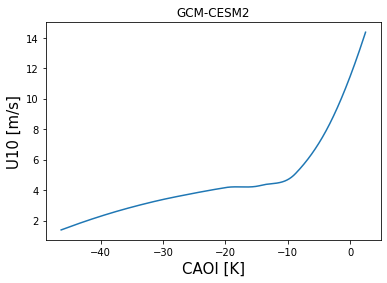

In [18]:
from skmisc.loess import loess
index = np.isnan(bin_means_x*bin_means)==False

# plt.plot(bin_means_x, bin_means)
l = loess(bin_means_x[index], bin_means[index])
l.fit()
pred = l.predict(bin_means_x[index], stderror=True)
conf = pred.confidence()

lowess = pred.values
plt.plot(bin_means_x[index], lowess)
plt.ylabel('U10 [m/s]',fontsize='15')
plt.xlabel('CAOI [K]',fontsize='15')
plt.title('GCM-CESM2')

In [19]:
bin_means_x_gcm = bin_means_x[index]
bin_means_gcm   = lowess

In [ ]:
x_gcm = []
y_gcm = []


In [ ]:
x_gcm.append(bin_means_x_gcm)
y_gcm.append(bin_means_gcm)

# Observations

In [20]:
import glob
merlist = np.sort(glob.glob('../data_merra/lat_30_70/new/MERRA2_*.nc'))
sfclist = np.sort(glob.glob('../data_merra/lat_30_70/surface/new/MERRA2_*.nc'))


In [24]:
import netCDF4 as nc
import xarray as xr
p_mer_T   = []
p_mac_w   = []
sfc_mer_T = []
sfc_mer_P = []
sfc_mer_U = []
sfc_mer_V = []

for i in range(len(merlist)): #len(merlist)
    d_path = merlist[i]
    data   = nc.Dataset(d_path)
    # print(d_path)
    
    if i==0:
        merlat = data.variables['lat'][:]
        merlon = data.variables['lon'][:]
        merlev = data.variables['lev'][:]
        #shape latitude
        mer_lat = np.flip(merlat)
        mer_lat = np.array(mer_lat)
        #shape longitude
        mer_lon = np.array(merlon)
        
        
    merT   = data.variables['T'][:] #(time, lev, lat, lon)
    mer_T = np.array(merT[:,:,::-1,:])
    p_mer_T.extend(mer_T)
    
temp = np.array(p_mer_T)

for i in range(len(sfclist)): #len(merlist)
    s_path = sfclist[i]
    sdata  = nc.Dataset(s_path)
    # print(d_path)
    
    if i==0:
        sfclat = sdata.variables['lat'][:]
        sfclon = data.variables['lon'][:]
        #shape latitude
        sfc_lat = np.flip(sfclat)
        sfc_lat = np.array(sfc_lat)
        #shape longitude
        sfc_lon = np.array(sfclon)
        
    sfcT   = sdata.variables['TS'][:] 
    sfc_T = np.array(sfcT[:,::-1,:])
    sfc_mer_T.extend(sfc_T)
    
    sfcP   = sdata.variables['SLP'][:] 
    sfc_P = np.array(sfcP[:,::-1,:])
    sfc_mer_P.extend(sfc_P)
    
    sfcU   = sdata.variables['U10M'][:] 
    sfc_U = np.array(sfcU[:,::-1,:])
    sfc_mer_U.extend(sfc_U)
    
    sfcV   = sdata.variables['V10M'][:] 
    sfc_V = np.array(sfcV[:,::-1,:])
    sfc_mer_V.extend(sfc_V)
    
sfctemp = np.array(sfc_mer_T)
sfcpres = np.array(sfc_mer_P)
sfcwind = np.sqrt(np.array(sfc_mer_U)**2 + np.array(sfc_mer_V)**2)

wind = np.array(sfcwind)

    

In [25]:
merlev

masked_array(data=[1000.,  850.,  800.],
             mask=False,
       fill_value=1e+20)

In [26]:
print(sfclat[0],sfclat[-1])
print(sfc_lat[0],sfc_lat[-1])
print(mer_lat[0],mer_lat[-1])



69.5 30.5
30.5 69.5
30.5 69.5


In [27]:
print(np.shape(temp[:,1,:,:]))
print(np.min(sfcpres))

(1096, 40, 360)
93888.76


In [28]:
theta_850 = np.array(np.multiply(temp[:,1,:,:], (sfcpres/85000)**(Rd/Cp)))


In [29]:
p_CAOI = np.array(np.subtract(sfctemp,theta_850))


In [30]:
maskm = np.ones((1096,len(mer_lat),len(mer_lon)))

for a in range(len(mer_lat)):
    for b in range(len(mer_lon)):
        if globe.is_land(mer_lat[a], mer_lon[b])==True:
            maskm[:,a,b] = 0

In [31]:
plot_CAOI = np.array(np.multiply(maskm,p_CAOI))
plot_wind = np.array(np.multiply(maskm,wind))


In [32]:
plot_mer_theta = plot_CAOI.ravel()
plot_mac_wind  = plot_wind.ravel()

In [33]:
print(np.min(plot_mer_theta), np.min(plot_mac_wind))

-39.90731044295063 0.0


In [34]:
ind = np.argsort(plot_mer_theta)
xx = np.sort(plot_mer_theta)
yy = plot_mac_wind[ind]

In [35]:
x_new = xx[xx<np.max(xx)]
y_new = yy[xx<np.max(xx)]

xx_new = x_new[y_new>0]
yy_new = y_new[y_new>0]

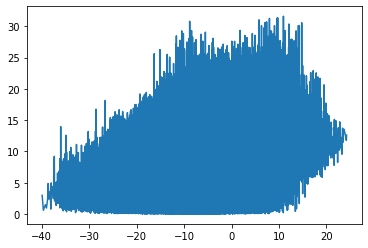

In [36]:
plt.plot(xx_new,yy_new)

In [37]:
bin_means, bin_edges, binnumber = stats.binned_statistic(xx_new, yy_new, 'mean', bins=1000)
bin_means_x, bin_edges_x, binnumber_x = stats.binned_statistic(xx_new, xx_new, 'mean', bins=1000)


In [38]:
index = np.isnan(bin_means_x*bin_means)==False

Text(0.5, 1.0, 'observation')

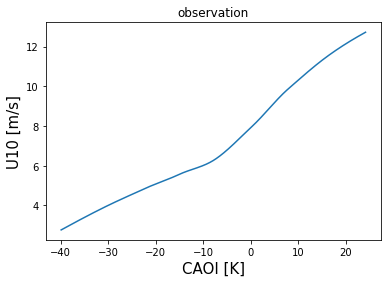

In [39]:



# plt.plot(bin_means_x, bin_means)
l = loess(bin_means_x[index], bin_means[index])
l.fit()
pred = l.predict(bin_means_x[index], stderror=True)
conf = pred.confidence()

lowess = pred.values
plt.plot(bin_means_x[index], lowess)
plt.ylabel('U10 [m/s]',fontsize='15')
plt.xlabel('CAOI [K]',fontsize='15')
plt.title('observation')

In [40]:
bin_means_x_obs = bin_means_x[index]
bin_means_obs   = lowess

Text(0.5, 0, 'CAOI [K]')

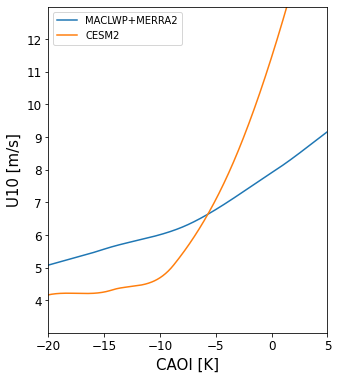

In [41]:
fig= plt.figure(figsize=(5, 6))
plt.plot(bin_means_x_obs, bin_means_obs, label='MACLWP+MERRA2')
plt.plot(bin_means_x_gcm, bin_means_gcm, label='CESM2')
plt.xticks(np.arange(-20,6,5),fontsize='12')
plt.yticks(np.arange(4,13),fontsize='12')
plt.xlim([-20,5])
plt.ylim([3,13])
plt.legend()
plt.ylabel('U10 [m/s]',fontsize='15')
plt.xlabel('CAOI [K]',fontsize='15')
# plt.title('MACLWP wind vs MERRA2 M\nfor 30N to 70N ocean only\n850hPa')

# PPE

In [39]:
enn = np.arange(200,251)

In [40]:
ppe_var = ['U10', 'PSL', 'T850','TREFHT']

In [41]:
for en in enn:
    for i in ppe_var: #TREFHT was used since no TS. Should double check this.
        d_path = '/glade/campaign/cgd/projects/ppe/cam_ppe/rerun_PPE_250/PD/PD_timeseries/PPE_250_ensemble_PD.'+f'{en:03d}'+'/atm/hist/cc_PPE_250_ensemble_PD.'+f'{en:03d}'+'.h1.'+str(i)+'.nc'
        data =xr.open_dataset(d_path)
        
        if en == enn[0]:
            lon  = data.variables['lon'][:]  #(lon: 288) [0.0, 1.25, 2.5, ... 356.25, 357.5, 358.75]
            lat  = data.variables['lat'][:]  #(lat: 192) [-90.0 , -89.057592, -88.115183, ... 88.115183,  89.057592, 90.0]
            time = data.variables['time'][:] #(time: 36)
            
        locals()[str(en)+'_'+i] = data.variables[i][:]

In [42]:
x_lat = np.array(lat)
lat_ind1 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (30)).argmin()])[0]
lat_ind2 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (70)).argmin()])[0]
lat_new  = lat[lat_ind1[0]:lat_ind2[0]]

mask = np.ones((len(time),len(lat_new),len(lon)))

for a in range(len(lat_new)):
    for b in range(len(lon)):
        if globe.is_land(lat_new[a], lon[b]-180.)==True:
            mask[0:len(time),a,b] = 0

for en in enn:
    for i in ppe_var: #
        tmp  = locals()[str(en)+'_'+i]
        tmp2 = tmp[:,lat_ind1[0]:lat_ind2[0],:]
        locals()['MID'+i+'_'+str(en)] = np.multiply(mask,tmp2)

In [43]:
for en in enn:
    locals()['theta_850_'+str(en)] = np.multiply(locals()['MIDT850_'+str(en)],(np.divide(locals()['MIDPSL_'+str(en)],85000))**(Rd/Cp))

In [ ]:
np.shape(theta_850_247)

In [44]:
for en in enn:
    locals()['M_'+str(en)]   = np.array(np.subtract(locals()['MIDTREFHT_'+str(en)],locals()['theta_850_'+str(en)])).reshape(-1)
    locals()['U10_'+str(en)] = np.array(locals()['MIDU10_'+str(en)]).reshape(-1)

In [ ]:
np.max(U10_246)

In [ ]:
from scipy import stats
from skmisc.loess import loess

Text(0.5, 0, 'CAOI [K]')

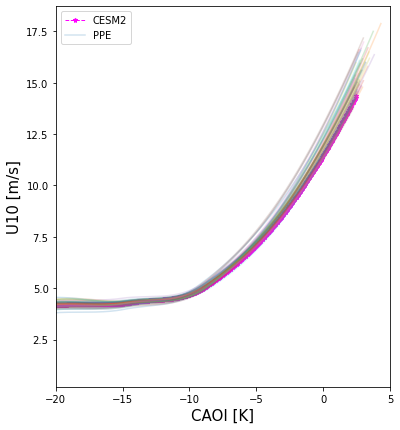

In [47]:
fig= plt.figure(figsize=(6, 7))
plt.plot(bin_means_x_gcm, bin_means_gcm,color='magenta' ,marker='*', linestyle='dashed',
     markersize=5,linewidth=1, label='CESM2') #marker='*', markersize=12,
# plt.plot(bin_means_x_obs, bin_means_obs,color='blue' ,marker='*', linestyle='dashed',
#      markersize=5,linewidth=1, label='Observations')
for en in enn:
    x = locals()['M_'+str(en)]
    y = locals()['U10_'+str(en)]
    ind = np.argsort(x)
    xx = np.sort(x)
    yy = y[ind]
    
    indx = np.isnan(xx*yy)==False
    
    bin_means, bin_edges, binnumber = stats.binned_statistic(xx[indx], yy[indx], 'mean', bins=1000)
    bin_means_x, bin_edges_x, binnumber_x = stats.binned_statistic(xx[indx], xx[indx], 'mean', bins=1000)
    
    index = np.isnan(bin_means_x*bin_means)==False
    
    # plt.plot(bin_means_x, bin_means)
    l = loess(bin_means_x[index], bin_means[index])
    l.fit()
    pred = l.predict(bin_means_x[index], stderror=True)
    conf = pred.confidence()

    lowess = pred.values
    
    
    if en==250:
        plt.plot(bin_means_x[index], lowess, alpha=0.2,label='PPE')
        
    else:
        plt.plot(bin_means_x[index], lowess, alpha=0.2)
    

# plt.plot(bin_means_x_obs, bin_means_obs, label='MACLWP+MERRA2')
# plt.plot(bin_means_x_gcm, bin_means_gcm, label='CESM2')
# plt.xticks(np.arange(-20,6,5),fontsize='12')
# plt.yticks(np.arange(4,13),fontsize='12')
plt.xlim([-20,5])

plt.legend()
plt.ylabel('U10 [m/s]',fontsize='15')
plt.xlabel('CAOI [K]',fontsize='15')
# plt.title('CAM6 PPE')
# plt.savefig('ppe.png')